In [108]:
import pandas as pd
df = pd.read_csv("ground_truth_admissions_answers_norag_mixtral7b.csv")
df['contexts'] = df['contexts'].apply(lambda x: eval(x) if isinstance(x, str) else [''])

df['ground_truth'] = df['ground_truth'].fillna('')
print(df['ground_truth'].tolist())
# df['contexts'] = df['contexts'].apply(lambda x: [[]])

['The applicants to the Doctor of Audiology (Au.D.) program at the University must provide three letters of recommendation as part of their application.', 'Graduate students in certain degree programs can access the intellectual resources of faculty from other universities in the State University System at UF through cooperative degree programs. In these approved areas, the faculty members hold Graduate Faculty status at UF and their resources are available to students at UF. Students need prior approval from their graduate coordinator, their supervisory committee chair, and the Dean of the Graduate School to participate.', 'The deadline for submitting freshman applications to the University of Florida for priority consideration in the admissions process is November 1.', 'Scholars are normally limited to one term on their home campus that is not their final term. To access resources from faculty at other universities in the State University System, students need prior approval from the

In [109]:
data_dict = {
'question': df['question'].tolist(),
'ground_truth': df['ground_truth'].tolist(),
'contexts': df['contexts'].tolist(),
'answer': df['answer'].tolist(),
'evolution_type': df['evolution_type'].tolist(),
'episode_done': df['episode_done'].tolist()

}

In [110]:
from datasets import Dataset 

dataset = Dataset.from_dict(data_dict)
dataset

Dataset({
    features: ['question', 'ground_truth', 'contexts', 'answer', 'evolution_type', 'episode_done'],
    num_rows: 9
})

In [111]:
from ragas.metrics import (
    context_relevancy,
    faithfulness,
    answer_relevancy,
)

In [112]:
# LangChain supports many other chat models. Here, we're using Ollama
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# supports many more optional parameters. Hover on your `ChatOllama(...)`
# class to view the latest available supported parameters
llm = ChatOllama(model="mistral")
prompt = ChatPromptTemplate.from_template("Tell me a short joke about {topic}")

# using LangChain Expressive Language chain syntax
# learn more about the LCEL on
# /docs/concepts/#langchain-expression-language-lcel
chain = prompt | llm | StrOutputParser()

# for brevity, response is printed in terminal
# You can use LangServe to deploy your application for
# production
print(chain.invoke({"topic": "Space travel"}))

 Why don't astronauts like to fight in space?

Because the universe is full of stars, not battles! 🌠😜


In [113]:
from ragas.llms import LangchainLLMWrapper

mistral_wrapper = LangchainLLMWrapper(langchain_llm=llm)
faithfulness.llm = mistral_wrapper
answer_relevancy.llm = mistral_wrapper
context_relevancy.llm = mistral_wrapper

In [114]:
# evaluate
from ragas import evaluate
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
fast_embeddings = FastEmbedEmbeddings(model_name="BAAI/bge-base-en")

result = evaluate(
    dataset.select(range(9)),  # showing only 3 for demonstration
     metrics=[
        answer_relevancy,
        context_relevancy,
        faithfulness
    ],
    embeddings=fast_embeddings
)

result

Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

{'answer_relevancy': 0.9842, 'context_relevancy': 1.0000, 'faithfulness': 0.6364}

In [115]:
df = result.to_pandas()
df.head()

,question,ground_truth,contexts,answer,evolution_type,episode_done,answer_relevancy,context_relevancy,faithfulness
0,What are the requirements for letters of reco...,The applicants to the Doctor of Audiology (Au....,[No context],\nWhile I don't have real-time access to speci...,simple,True,0.975421,1,0.909091
1,"""How can graduate students in certain degree ...",Graduate students in certain degree programs c...,[No context],\nGraduate students at the University of Flori...,simple,True,0.977217,1,0.000000
2,What is the deadline for submitting freshman ...,The deadline for submitting freshman applicati...,[No context],\nThe deadline for submitting freshman applica...,simple,True,1.000000,1,1.000000


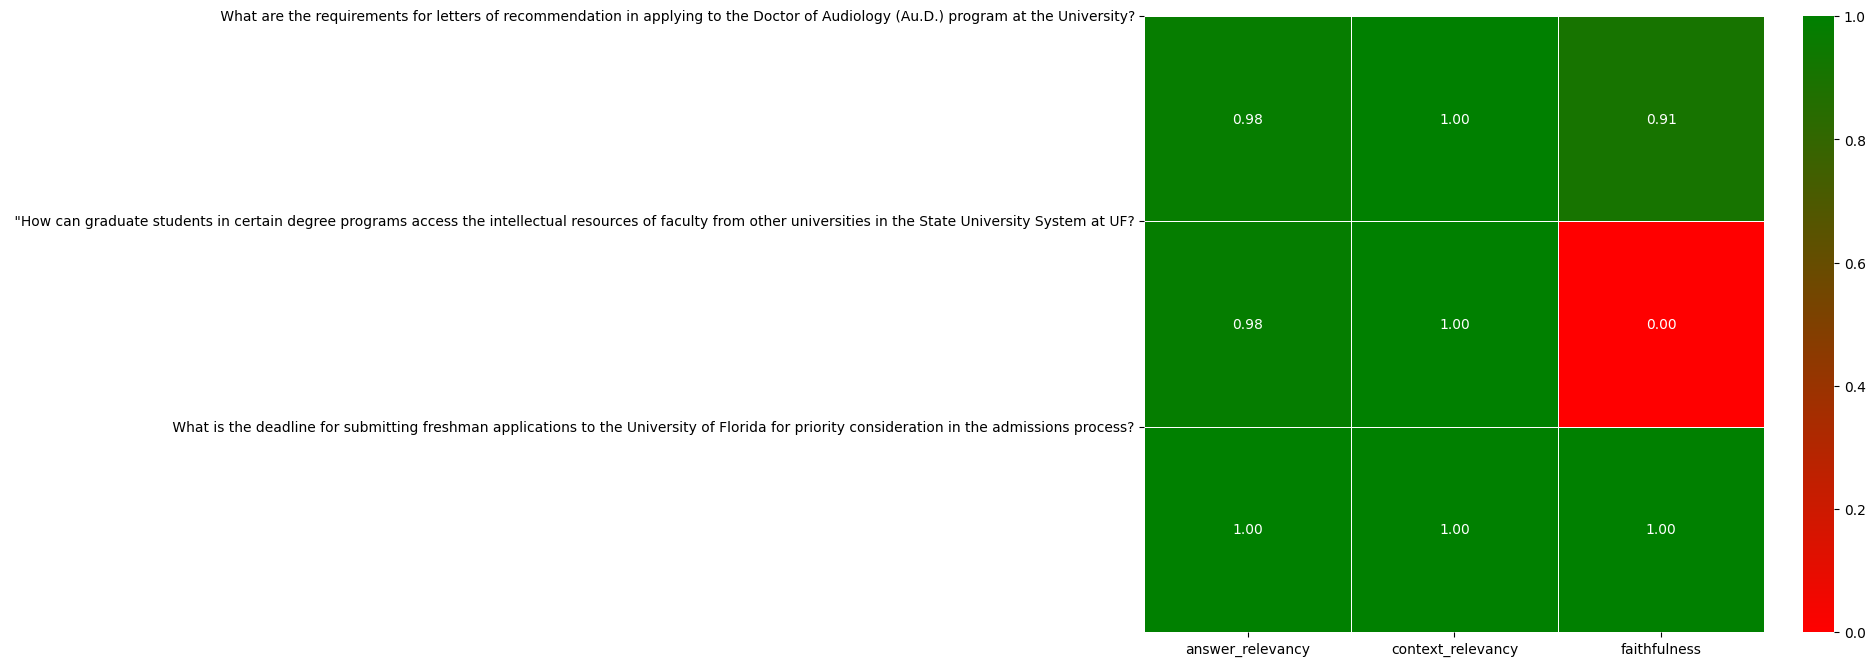

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


heatmap_data = df[['answer_relevancy', 'context_relevancy', 'faithfulness']]

cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()